# Portafolios de Inversión
## Tarea 7

Presenta : 

- José Armando Melchor Soto


---
### Librerías 



In [53]:
import pandas as pd 
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 

---

#### Indicaciones 

1.- Función de Métricas de Desempeño. 20%

Genera una función en python que reciba un data frame con la evolución histórica de n cantidad de estrategías de inversión y calcule todas las métricas de desempeño vistas en las dos clases anteriores Rendimiento, Volatilidad, Ratio de Sharpe, Downside, Upside, Omega, Beta, Alfa de Jensen, Ratio de Treynor, Ratio de Sortino.
 

2.- Backtesting de Portafolio. 50%

Asume que quieres invertir en un portafolio compuesto por las siguientes acciones mexicanas: LIVEPOLC1.MX, KOFUBL.MX, CEMEXCPO.MX, CHDRAUIB.MX, CUERVO.MX, LABB.MX, RA.MX.
Debido a que no sabes como ponderarlos, decides realizar el backtesting para el portafolio para cuatro estrategias de Asset Allocation: Mínima Varianza, Máximo de Sharpe, Semivarianza Target y Omega.
Realiza el backtesting utilizando datos para simulación del 23-06-2024 hasta el 23-06-2025, toma un período anterior con el mismo horizonte temporal para optimizar las ponderaciones.
Recuerda siempre comparar con una estrategia de inversión pasiva, en este caso la opción lógica es el IPC México.
Gráfica la evolución histórica de las cinco alternativas de inversión.
Con los resultados del backtesting histórico calcula e interpreta las métricas de desempeño para las cinco alternativas de estrategias de inversión simuladas.
 

3.- Selección de Estrategia de Inversión. 20%

Utilizando los resultados de tu backtesting y las métricas de desempeño, selecciona una estrategia de inversión. Realiza una conclusión clara, breve y robusta de porque es la mejor estrategia PARA TI, apoyate en las métricas obtenidas y en tu perfil de aversión al riesgo.
 

4.- Calculo de Pesos para Portafolio Real. 10%

En base a la estrategia de Asset Allocation seleccionada en el punto anterior, calcula los pesos eficientes y la cantidad de acciones que utilizarías para invertir en la realidad en tu portafolio. Recuerda tomar la ventana de datos más reciente, en función del horizonte temporal tomado. 

---

#### Funciones 

##### Función Mínima Varianza 

In [54]:
def opt_min_var(rets):
    
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    var = lambda w: w.T @ cov @ w
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=var, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Máximo de Sharpe

In [55]:
def opt_max_sharpe(rets, rf):
    
    E=rets.mean()
    cov=rets.cov()
    n_assets = len(rets.columns)
    
    rs = lambda w: -((w.T @ E - rf/252) / np.sqrt(w.T @ cov @ w))
    
    w0=np.ones(n_assets)/n_assets
    
    bounds=[(0, 1)]*n_assets
    
    constraint=lambda w: sum(w)-1
    
    result=minimize(fun=rs, x0=w0, bounds=bounds, constraints={'fun': constraint, 'type': 'eq'}, tol=1e-16)
    
    return result.x

##### Función Semi-Varianza Target

In [56]:
def objetivo (rets:pd.DataFrame , rets_b : pd.DataFrame ,corr:pd.DataFrame):
    
    rets, rets_b = rets.align(rets_b, join='inner', axis=0)
    diffs=rets - rets_b.values
    rends_below_bench = diffs[diffs < 0].fillna(0)
    target_downside_risk=np.array(rends_below_bench.std())
    target_semivarmatrix= corr * (target_downside_risk.reshape(len(rets.columns), 1) @ target_downside_risk.reshape(1, len(rets.columns)))

    objectivo = lambda w: (w.T @ target_semivarmatrix @ w)

    n = len(rets.keys())
    w_inicial = np.ones(n)/n
    bounds = [(0,1)]*n
    tol = 1e-9
    rest = lambda w: np.sum(w) - 1
    
    obj = minimize(
    fun=objectivo,
    x0=w_inicial,
    bounds=bounds,
    constraints={'fun': rest, 'type': 'eq'},
    tol=tol)

    w_objetivo = obj.x

    return dict(zip(rets.columns, w_objetivo))

##### Función Omega


In [57]:
def scipy_omega(rets: pd.DataFrame):
    n = len(rets.columns)
    w_inicial = np.ones(n) / n
    bounds = [(0, 1)] * n
    tol = 1e-16

    rets_below_zero = rets[rets < 0].fillna(0)
    rets_above_zero = rets[rets > 0].fillna(0)
    upside_risk=rets_above_zero.std()
    downside_risk = rets_below_zero.std()

    omega_ind = upside_risk / downside_risk

    Omega_neg = lambda w: -np.sum(w * omega_ind)

    constraints = {'fun': lambda w: np.sum(w) - 1, 'type': 'eq'}

    result = minimize(
        fun=Omega_neg,
        x0=w_inicial,
        bounds=bounds,
        constraints=constraints,
        tol=tol
    )

    w_omega = result.x
    return dict(zip(rets.columns, w_omega))

##### Función Backtesting 

In [58]:
def backtesting(prices: pd.DataFrame, benchmark: pd.DataFrame, weights: dict, capital: float):
    
    # Obtener rendimientos de precios y benchmark
    rets_assets = prices.pct_change().dropna()
    rets_benchmark = benchmark.pct_change().dropna()
    
    # data frame vacio para llenar historia
    
    df = pd.DataFrame(index=rets_assets.index)
    
    # Obtener evolución para cada estrategia dada
    for strategy in weights.keys():
        # para benchmark
        if strategy == 'benchmark':
            temp = rets_benchmark + 1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values            
    
        # para otras estrategias

        else:
            temp = (rets_assets * weights.get(strategy)).sum(axis=1)+1
            temp.iloc[0]=capital
            temp = temp.cumprod()
            df[strategy] = temp.values    

    # Graficar la evolucion para ambos portafolios
    plt.figure(figsize=(12,6))
    plt.plot(df, label=df.keys())
    plt.title('Backtesting of Strategies')
    plt.xlabel('Date')
    plt.ylabel('Portafolio Value')
    plt.legend()
    plt.show()


    return df

##### Función Métricas de Desempeño

In [59]:
def metricas_anuales(history, rf):
    # Returns
    rets= history.pct_change().dropna()
    
    # Matriz de Cov
    cov_hist = rets.cov()

    # Dataframe
    metricas = pd.DataFrame(index=rets.columns)

    # Rendimiento 
    metricas['Rendimiento Promedio Anual'] = R_p = rets.mean()*252*100
    
    # Volatilidad 
    metricas['Volatilidad Anual'] = vol_anual = rets.std()*np.sqrt(252)*100
    
    # Ratio de Sharpe
    metricas['Ratio de Sharpe'] = (R_p - rf) / vol_anual

    # Downside Risk
    metricas['Downside Risk'] = downside = rets[rets < 0].std() * np.sqrt(252) * 100

    # Upside Risk
    metricas['Upside Risk'] = upside = rets[rets > 0].std() * np.sqrt(252) * 100

    # Omega
    metricas['Omega'] =omega= upside / downside

    # Beta

    covs = cov_hist['Benchmark']
    varianza_market = covs['Benchmark']
    metricas['Beta'] = beta = covs / varianza_market

    # Alfa de Jensen

    R_m = rets['Benchmark']
    alpha_Jensen = R_p - (rf + beta * (R_m - rf))

    # Ratio de Treynor
    metricas['Ratio de Treynor'] = (R_p - rf) / beta

    # Ratio de Sortino
    metricas['Ratio de Sortino'] = (R_p - rf) / downside

    return metricas.T

---

#### Construcción del Portafolio 

##### Activos 

| **Empresa**                             | **Ticker**        | **Sector Económico**                          |
|----------------------------------------|-------------------|-----------------------------------------------|
| El Puerto de Liverpool, S.A.B. de C.V. | LIVEPOLC-1.MX     | Consumo                 |
| Coca-Cola FEMSA, S.A.B. de C.V.        | KOFUBL.MX         | Consumo Básico             |
| Cemex, S.A.B. de C.V.                  | CEMEXCPO.MX       | Materiales           |
| Grupo Comercial Chedraui               | CHDRAUIB.MX       | Consumo Básico          |
| Becle, S.A.B. de C.V. José Cuervo    | CUERVO.MX         | Consumo Básico       |
| Genomma Lab Internacional, S.A.B. de C.V. | LABB.MX         | Salud  |
| Rassini, S.A.B. de C.V.                | RA.MX             | Industriales                   |



##### Benchmark

- IPC Índice de Precios y Cotizaciones de la Bolsa Mexicana de Valores (^MXX).

---

#### Importación de los datos

In [60]:
tickers = ['LIVEPOLC-1.MX', 'KOFUBL.MX', 'CEMEXCPO.MX', 'CHDRAUIB.MX', 'CUERVO.MX', 'LABB.MX', 'RA.MX']

opt_prices = yf.download(tickers, start='2023-06-23', end='2024-06-23', progress=False)['Close']

bt_prices = yf.download(tickers,  start='2024-06-23', end='2025-06-23', progress=False)['Close']

benchmark = yf.download(['^MXX'], start='2024-06-23', end='2025-06-23', progress=False)['Close']

##### Rendimientos activos

In [61]:
opt_rets = opt_prices.pct_change().dropna()
corr = opt_rets.corr()

##### Rendimientos benchmark

In [62]:
rets_b = benchmark.pct_change().dropna()

#### Rendimientos Backtesting

In [63]:
rets_bt = bt_prices.pct_change().dropna()

---

#### Asset Allocation 

##### Mínima Varianza

In [64]:
w_minvar = opt_min_var(opt_rets)
dict(zip(opt_rets.columns, w_minvar))

{'CEMEXCPO.MX': 0.046118979256300714,
 'CHDRAUIB.MX': 0.30905603153151856,
 'CUERVO.MX': 0.11713467671805179,
 'KOFUBL.MX': 0.2164678582874239,
 'LABB.MX': 0.0014375843650323915,
 'LIVEPOLC-1.MX': 0.2471785882235787,
 'RA.MX': 0.06260628161809388}

##### Máximo de Sharpe 

In [65]:
w_maxsharpe = opt_max_sharpe(opt_rets, rf=0.045)
dict(zip(opt_rets.columns, w_maxsharpe))

{'CEMEXCPO.MX': 3.508238531009532e-17,
 'CHDRAUIB.MX': 0.537796178613297,
 'CUERVO.MX': 0.0,
 'KOFUBL.MX': 0.0,
 'LABB.MX': 0.09006472130461333,
 'LIVEPOLC-1.MX': 0.37213910008208984,
 'RA.MX': 0.0}

##### Semi-Varianza target

In [66]:
w_semivar= objetivo(opt_rets, rets_b, corr)
w_semivar

{'CEMEXCPO.MX': 0.14285714285714285,
 'CHDRAUIB.MX': 0.14285714285714285,
 'CUERVO.MX': 0.14285714285714285,
 'KOFUBL.MX': 0.14285714285714285,
 'LABB.MX': 0.14285714285714285,
 'LIVEPOLC-1.MX': 0.14285714285714285,
 'RA.MX': 0.14285714285714285}

##### Ratio Omega

In [67]:
omega = scipy_omega(opt_rets)
omega

{'CEMEXCPO.MX': 1.7632125819594537e-19,
 'CHDRAUIB.MX': 1.0,
 'CUERVO.MX': 0.0,
 'KOFUBL.MX': 6.4571063532475e-17,
 'LABB.MX': 0.0,
 'LIVEPOLC-1.MX': 1.4787513179875976e-19,
 'RA.MX': 4.8363490344779524e-20}

---

### Backtesting de Portafolio

##### Capital 

In [68]:
capital = 1000000

##### Estrategias a usar

In [69]:
w_dict = {
    'Min Varianza': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Semi-Varianza target': w_semivar,
    'Ratio Omega': omega,
    'Benchmark': 1
}

##### Función Aplicada 

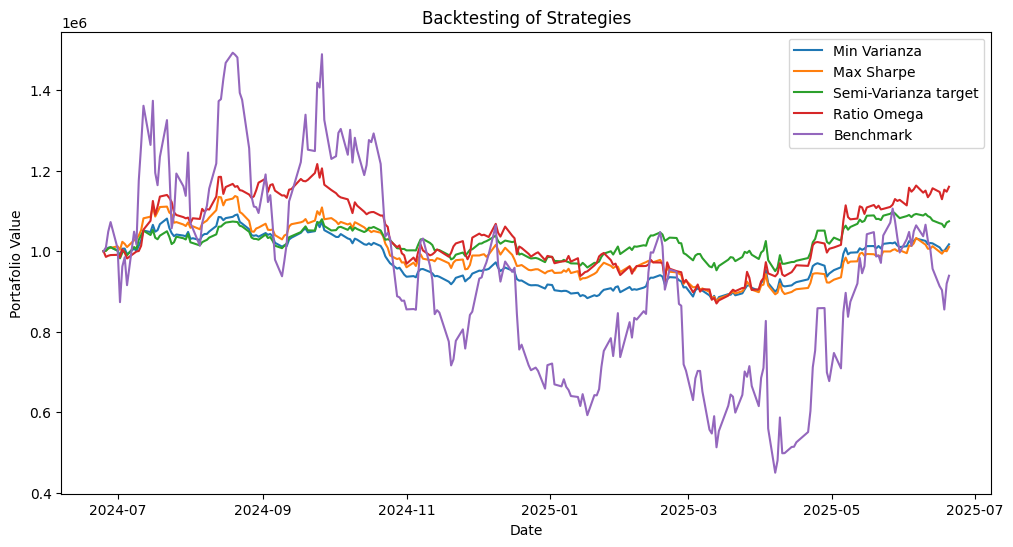

In [70]:
history = backtesting(bt_prices, benchmark, w_dict, capital)

#### Métricas de Desempeño

In [71]:
Desempeño = metricas_anuales(history, 0.045)
Desempeño

,Min Varianza,Max Sharpe,Semi-Varianza target,Ratio Omega,Benchmark
Rendimiento Promedio Anual,3.064646,2.787527,8.673199,18.722520,60.712391
Volatilidad Anual,16.298337,18.447179,16.368068,26.702499,114.576474
Ratio de Sharpe,0.185273,0.148669,0.527136,0.699467,0.529493
Downside Risk,10.253929,11.738906,11.465138,16.355630,80.255965
Upside Risk,10.305355,11.869968,9.840446,18.943980,68.883120
Omega,1.005015,1.011165,0.858293,1.158254,0.858293
Beta,0.126175,0.116057,0.142857,0.131430,1.000000
Ratio de Treynor,23.932236,23.630945,60.397391,142.109884,60.667391
Ratio de Sortino,0.294487,0.233627,0.752560,1.141963,0.755924


#### Interpretación

Con base en las métricas presentadas, se puede interpretar que los activos seleccionados no son muy adecuados para invertir en este momento, ya que muestran resultados bastante deficientes. En general, ninguna de las estrategias resulta especialmente atractiva, principalmente porque la relación entre rendimiento y volatilidad es baja para todas. Aun así, si tuviera que elegir una, la estrategia basada en el Ratio Omega sería la opción más razonable.

Esta estrategia destaca principalmente porque, aunque tiene una volatilidad anual bastante alta 26.70%, también ofrece el mayor rendimiento promedio anual 18.72% entre todas. Además, presenta el mejor Ratio de Sharpe 0.699, lo que significa que se obtienen 0.699 unidades de rendimiento por cada unidad de riesgo asumida, una cifra que, aunque no excelente, sí es superior a las otras estrategias.

En cuanto al riesgo, esta estrategia tiene un Downside Risk de 16.35%, lo que indica que existe la posibilidad de experimentar rendimientos negativos. Sin embargo, s Upside Risk es de 18.94%, lo que sugiere un mayor potencial de ganancias. Esto se refleja también en su Ratio Omega de 1.15, lo que significa que hay más rendimientos positivos que negativos, una señal favorable.

También resalta su Beta de 0.13, lo cual indica que es una estrategia bastante defensiva con respecto al mercado, siendo la segunda más baja entre las opciones. Además, tiene el mejor Ratio de Treynor 142.07, lo que muestra que es la estrategia con mejor desempeño en relación con el riesgo de mercado. En el Ratio de Sortino 1.14 también se posiciona como la mejor, lo que indica una buena relación entre rendimiento y riesgo negativo.

En conclusión la estrategia de Ratio Omega es la que presenta las mejores métricas de desempeño, no parece ser una opción especialmente buena para invertir el capital, ya que los activos seleccionados para este portafolio, incluyendo el benchmark, no son los más sólidos. Por lo tanto, sería recomendable nbuscar la selección de activos y buscar mejores opciones.


---

### Selección de Estrategias de Inversión 

##### Perfil de aversión al Riesgo  : Averso al riesgo

Basándome en los resultados del backtesting y las métricas de desempeño, la estrategia que mejor se ajusta a mi perfil de aversión al riesgo es la basada en el Ratio Omega. Aunque ninguna de las estrategias es ideal, esta es la que presenta las métricas más sólidas en comparación con las demás.

Su Ratio de Sharpe , Ratio de Sortino y Ratio de Treynor son los más altos, lo que indica un mejor desempeño ajustado al riesgo, especialmente al riesgo negativo. Además, su Beta refleja que es una estrategia defensiva frente al mercado, lo cual es lo mejor para un perfil averso al riesgo ,como  lo es el mío.

Aunque su relación rendimiento/volatilidad no es la mejor, sí ofrece el mayor rendimiento anual rendimiento , lo que la convierte en la opción más robusta dentro de este conjunto limitado de alternativas. Por todo esto, si tuviera que elegir una, sin duda me quedo con la estrategia del Ratio Omega.

---

### Calculo de Pesos para Portafolio Real

In [75]:
re_opt = pd.DataFrame(index=  opt_rets.columns)
re_opt['w'] = scipy_omega(rets_bt)
re_opt['Cash'] = re_opt['w'] * capital
re_opt['No. Acciones'] = np.floor(re_opt['Cash'] / bt_prices.iloc[-1])
re_opt



,w,Cash,No. Acciones
Ticker,,,
CEMEXCPO.MX,6.538223e-17,6.538223e-11,0.0
CHDRAUIB.MX,7.213032e-16,7.213032e-10,0.0
CUERVO.MX,3.201819e-16,3.201819e-10,0.0
KOFUBL.MX,1.000000e+00,1.000000e+06,5523.0
LABB.MX,2.930324e-16,2.930324e-10,0.0
LIVEPOLC-1.MX,2.766493e-16,2.766493e-10,0.0
RA.MX,2.766211e-15,2.766211e-09,0.0


In [76]:
re_opt['w'].sum()

1.000000000000004